# Imports

In [1]:
from pathlib import Path

import numpy as np
from scipy.sparse import coo_matrix
import contextlib
import os
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# Reading files

In [2]:

@contextlib.contextmanager
def fdopen(fname, mode, perms=0o600, encoding=None):  # pragma: no cover
    """
    Context manager for opening files with correct permissions.

    Args:
        fname (str): Path to file to open for reading/writing
        mode (str): Mode in which the file is opened (see help for builtin `open()`)
        perms (int): Permission mask (see help for `os.open()`)
        encoding (str): The name of encoding used to decode or encode the file.
    """
    if 'r' in mode:
        flags = os.O_RDONLY
    elif 'w' in mode:
        flags = os.O_WRONLY | os.O_CREAT | os.O_TRUNC
    elif 'a' in mode:
        flags = os.O_WRONLY | os.O_CREAT
    else:
        raise RuntimeError(f'Unsupported mode: {mode}')

    file_object = open(os.open(fname, flags, perms), mode=mode, encoding=encoding)  # noqa: SCS109

    try:
        yield file_object
    finally:
        file_object.close()

In [3]:
def read_gset(filename, negate=True):
    """
    Reading Gset and transform it into sparse matrix

    Args:
        filename (str): The path and file name of the data.
        negate (bool): whether negate the weight of matrix or not.  Default: ``True``.

    Returns:
        coo_matrix, matrix representation of graph.

    Examples:
        >>> from qaia.utils import read
        >>> G = read.read_gset('data/Gset/G1.txt')
    """
    with fdopen(filename, "r") as f:
        data = f.readlines()

    n_v, n_e = (int(i) for i in data[0].strip().split(" "))
    graph = np.array([[int(i) for i in j.strip().split(" ")] for j in data[1:]])
    if n_e != graph.shape[0]:
        raise ValueError(f"The number of edges is not matched, {n_e} != {graph.shape[0]}")
    out = coo_matrix(
        (
            np.concatenate([graph[:, -1], graph[:, -1]]),
            (
                np.concatenate([graph[:, 0] - 1, graph[:, 1] - 1]),
                np.concatenate([graph[:, 1] - 1, graph[:, 0] - 1]),
            ),
        ),
        shape=(n_v, n_v),
    )

    if negate:
        return -out

    return out


G = read_gset('G1.txt')

# Original DSB

In [4]:
class QAIA:
    r"""
    The base class of QAIA.

    This class contains the basic and common functions of all the algorithms.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N x 1)`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
    """

    # pylint: disable=too-many-arguments
    def __init__(self, J, h=None, x=None, n_iter=1000, batch_size=1):
        """Construct a QAIA algorithm."""
        # J represents the coupling matrix between spins (interaction strengths)
        self.J = J # J is an N*N matrix
        
        # If h (external field) is provided as a 1D array, reshape it to a column vector
        if h is not None and len(h.shape) < 2:
            h = h[:, np.newaxis] # If h has only one axis, one more is added for proper broadcasting in calculations
        self.h = h
        
        # x represents the continuous spin values
        self.x = x
        
        # N is the number of spins in the system
        self.N = self.J.shape[0] 
        
        # Number of iterations for the algorithm to run
        self.n_iter = n_iter
        
        # Number of parallel instances to simulate (for statistical sampling)
        self.batch_size = batch_size

    def initialize(self):
        """Randomly initialize spin values."""
        # Initialize spins with small random values between -0.01 and 0.01
        # This prevents any initial bias and allows the dynamics to evolve naturally
        self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5) # makes a matrix of size N*batch_size with values between -0.001 and 0.001

    def calc_cut(self, x=None):
        r"""
        Calculate cut value.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        # For cut calculations, we need the sign of spin values (+1 or -1)
        if x is None:
            sign = np.sign(self.x) #if x is not provided, the sign of x in the QAIA class is returned
        else:
            sign = np.sign(x) #if x is provided, the sign of x in the is returned

        # Calculate the cut value using the formula: 0.25 * (sum(J_ij * σ_i * σ_j) - sum(J_ij))
        # This is used in graph partitioning problems to measure the quality of a cut
        return 0.25 * np.sum(self.J.dot(sign) * sign, axis=0) - 0.25 * self.J.sum() #0.25*Σ(j*σ*σ) - 0.25*Σj

    def calc_energy(self, x=None):
        r"""
        Calculate energy.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        # Get the discretized spin values (+1 or -1)
        if x is None:
            sign = np.sign(self.x)
        else:
            sign = np.sign(x)

        # Calculate the Ising model energy: -0.5 * sum(J_ij * σ_i * σ_j) - sum(h_i * σ_i)
        # If there's no external field (h), only calculate the coupling energy
        if self.h is None:
            return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0)
        return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0, keepdims=True) - self.h.T.dot(sign)

class SB(QAIA):
    r"""
    The base class of SB.

    This class is the base class for SB. It contains the initialization of
    spin values and momentum.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct SB algorithm."""
        # Initialize parent class (QAIA)
        super().__init__(J, h, x, n_iter, batch_size)
        
        # Convert J to sparse matrix format for computational efficiency
        self.J = csr_matrix(self.J)
        
        # Delta is a positive detuning frequency parameter in the SB algorithm
        self.delta = 1
        
        # dt is the time step for numerical integration
        self.dt = dt
        
        # p is the pumping amplitude that varies linearly from 0 to 1 over the iterations
        # This gradual increase helps avoid getting trapped in local minima
        self.p = np.linspace(0, 1, self.n_iter)
        
        # xi is a scaling parameter for the coupling term that affects the balance between 
        # the natural oscillation and the coupling-induced dynamics
        self.xi = xi
        
        # If xi is not provided, calculate a suitable value based on network properties
        # This auto-tuning helps ensure algorithm stability across different problem sizes
        if self.xi is None:
            self.xi = 0.5 * np.sqrt(self.N - 1) / np.sqrt(csr_matrix.power(self.J, 2).sum())
        
        self.x = x

        # Initialize the spin values and momentum
        self.initialize()

    def initialize(self):
        """Initialize spin values and momentum."""
        # If x is not provided, initialize with small random values
        if self.x is None:
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

        # Check that the size of x matches the number of spins
        if self.x.shape[0] != self.N:
            raise ValueError(f"The size of x {self.x.shape[0]} is not equal to the number of spins {self.N}")

        # y represents the momentum variables in the SB algorithm
        # Initialize momentum with small random values
        self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

class DSB(SB):  # noqa: N801
    r"""
    Discrete SB algorithm.

    Reference: `High-performance combinatorial optimization based on classical
    mechanics <https://www.science.org/doi/10.1126/sciadv.abe7953>`_.

    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    # pylint: disable=too-many-arguments
    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct DSB algorithm."""
        # Initialize parent class (SB)
        super().__init__(J, h, x, n_iter, batch_size, dt, xi)
        self.initialize()

    # pylint: disable=attribute-defined-outside-init
    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        # Iterate through the specified number of time steps
        for i in range(self.n_iter):
            # Update momentum (y) based on force terms
            if self.h is None:
                # Without external field:
                # Force = -detuning_term * position + coupling_term
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt
            else:
                # With external field:
                # Force = -detuning_term * position + coupling_term + external_field
                self.y += (
                    -(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(np.sign(self.x)) + self.h)
                ) * self.dt

            # Update position (x) based on momentum
            self.x += self.dt * self.y * self.delta

            # Apply constraint that |x| ≤ 1 (clamping)
            # If |x| > 1, set x to sign(x) and reset momentum to 0
            # This is a key feature of the Discrete Simulated Bifurcation (DSB) algorithm
            # that prevents oscillations and helps discretize the final solution
            cond = np.abs(self.x) > 1
            self.x = np.where(cond, np.sign(self.x), self.x)
            self.y = np.where(cond, np.zeros_like(self.y), self.y)

In [5]:
def test_dSB():
    """
    Description: Test DSB
    Expectation: success
    """
    N = G.shape[0]
    # np.random.seed(666)
    x = 0.01 * (np.random.rand(N, 1) - 0.5)
    y = 0.01 * (np.random.rand(N, 1) - 0.5)
    solver = DSB(G, n_iter=1)
    solver.x = x.copy()
    solver.y = y.copy()
    solver.update()
    y += (-(1 - solver.p[0]) * x + solver.xi * G @ np.sign(x)) * solver.dt
    x += y * solver.dt
    x = np.where(np.abs(x) > 1, np.sign(x), x)
    assert np.allclose(x, solver.x)


test_dSB()

# Testing QAIA class

In [6]:
# Create a simple coupling matrix J
# This could represent a graph with 4 nodes and weighted edges
J = np.array([
    [0, 1, 1, 0, 1],  # Node 0 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0],  # Node 1 connected to nodes 0, 2, 3
    [1, 1, 0, 1, 1],  # Node 2 connected to nodes 0, 1, 3, 4
    [0, 1, 1, 0, 1],  # Node 3 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0]   # Node 4 connected to nodes 0, 2, 3
])

# Initialize the QAIA class with our coupling matrix
qaia_instance = QAIA(J=J, batch_size=5)

# Initialize random spin values
qaia_instance.initialize()
print("Initial spin values:")
print(qaia_instance.x)

# Calculate the cut value using the initialized spins
cut_value = qaia_instance.calc_cut()
print("\nCut value using initialized spins:")
print(cut_value)

# Calculate the energy value using the initialized spins
energy_value = qaia_instance.calc_energy()
print("\nEnergy value using initialized spins:")
print(energy_value)



Initial spin values:
[[ 0.00933348  0.00029154 -0.00720258  0.00668641 -0.00116415]
 [-0.00764935  0.00441676  0.0023      0.00172532  0.00474602]
 [-0.00637845 -0.00603335 -0.00958715 -0.00382788  0.00914671]
 [-0.0081615   0.00518781 -0.00288776  0.00855368 -0.00118917]
 [-0.00900285  0.00244357  0.00674323 -0.00854982  0.00088951]]

Cut value using initialized spins:
[-3. -4. -6. -5. -6.]

Energy value using initialized spins:
[-2. -0.  4.  2.  4.]


# Testing SB Class

In [7]:
# Initialize the SB class with our coupling matrix
sb_instance = SB(J=J, batch_size=5)

# Check the initialized values
print("\nSpin values (x):")
print(sb_instance.x)

# Check the initialized values
print("\nSpin values (y):")
print(sb_instance.y)



Spin values (x):
[[ 0.00690927  0.00597882  0.00908099  0.00989393 -0.00462273]
 [ 0.00609093 -0.00741875 -0.00383208  0.00410324  0.00432178]
 [-0.0022432   0.00094646  0.00196559 -0.00518593 -0.00629671]
 [ 0.00334395  0.00950824  0.00761445  0.00389213  0.00356134]
 [-0.00903251 -0.00062951  0.00564453 -0.0078252  -0.00741859]]

Spin values (y):
[[-0.00992781 -0.0046193  -0.00674959 -0.00523933  0.00228478]
 [-0.00991486  0.00850685  0.00221516  0.00563377  0.00405745]
 [-0.00658921  0.00675403  0.00971024  0.00566524  0.00846632]
 [ 0.00189685 -0.00175388  0.00634689  0.00480557 -0.00660262]
 [ 0.00206272 -0.00251241  0.00409553 -0.00583183  0.00577183]]


# Testing DSB Class

Initial spin values:
[[-0.00711639 -0.00898746 -0.0033529  -0.00874632  0.00592644]
 [-0.00325398 -0.00417807 -0.00759833 -0.00056622  0.00631758]
 [-0.00615834  0.00032079  0.00339804 -0.00825453 -0.00492489]
 [-0.00928697 -0.00164208  0.00124335 -0.00717841 -0.00785569]
 [ 0.00035527  0.00234492  0.00659728 -0.00532495 -0.00620319]]

Initial cut values:
[-3. -5. -4.  0. -4.]

Final spin values:
[[-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]]

Final cut values:
[0. 0. 0. 0. 0.]

Final spin signs:
[[-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1.  1. -1. -1.]]

Final spin signs diagonal:
[-1. -1.  1. -1. -1.]

Improvement in cut value: [3. 5. 4. 0. 4.]


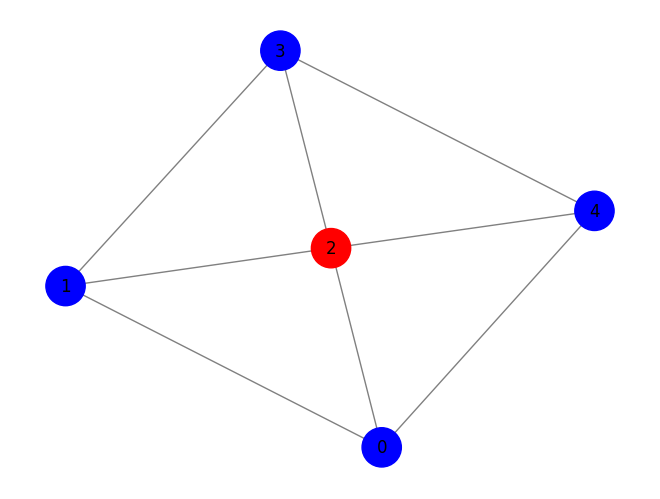

In [8]:

G = nx.from_numpy_array(J)
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=12)
# plt.show()

# Initialize the DSB class with our coupling matrix
dsb_instance = DSB(
    J=J,
    batch_size=5,  # Track 3 independent samples
    n_iter=5000     # Number of iterations to run
)

# Store the history of x values and cut values to visualize the evolution
x_history = []
cut_history = []

# Save initial state
x_history.append(dsb_instance.x.copy())
cut_history.append(dsb_instance.calc_cut())

# Run the update function
dsb_instance.update()

# Get final state
final_x = dsb_instance.x
final_cut = dsb_instance.calc_cut()

print("Initial spin values:")
print(x_history[0])
print("\nInitial cut values:")
print(cut_history[0])

print("\nFinal spin values:")
print(final_x)
print("\nFinal cut values:")
print(final_cut)

# Check the final state - the values should converge to near +1 or -1
print("\nFinal spin signs:")
print(np.sign(final_x))
print("\nFinal spin signs diagonal:")
diagonal_elements = np.sign(np.diagonal(final_x))
print(diagonal_elements)


# Calculate improvement in cut value
print(f"\nImprovement in cut value: {final_cut - cut_history[0]}")

node_colors = ['red' if v == 1 else 'blue' for v in diagonal_elements]
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=12)
plt.show()